In [1]:
import pandas as pd
# from retentioneering import datasets
from typing import Literal, Union, List, Optional, Iterable, get_args, Dict, Tuple
import numpy as np 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

from abc import ABC, abstractmethod
import warnings

import datetime
import itertools

In [2]:
import sys

sys.path.append('d:\\diplom\\product\\insight_pulse')

for path in sys.path:
    print(path)

D:\pythonProg\Python\Python312\python312.zip
D:\pythonProg\Python\Python312\DLLs
D:\pythonProg\Python\Python312\Lib
D:\pythonProg\Python\Python312
d:\diplom\.venv

d:\diplom\.venv\Lib\site-packages
d:\diplom\.venv\Lib\site-packages\win32
d:\diplom\.venv\Lib\site-packages\win32\lib
d:\diplom\.venv\Lib\site-packages\Pythonwin
d:\diplom\product\insight_pulse


In [3]:
from eventframing.eventframe import EventFrame
from eventframing.cols_schema import EventFrameColsSchema
from eventframing.event_type import EventType

from data_preprocessing.preprocessors_lib.add_start_end_events import AddStartEndEventsPreprocessor
from data_preprocessing.preprocessors_lib.split_sessions import SplitSessionsPreprocessor

from utils.time_units import TimeUnits
from utils.time_unit_period import TimeUnitPeriod

## Data Generation

In [75]:
def generate_user_events_data(num_users=1000, num_events=10, num_cities=10, num_os=2, num_rows=5000, seed=42):
    """
    Функция для генерации данных о событиях пользователей.
    """
    # Устанавливаем seed для генератора случайных чисел
    np.random.seed(seed)

    # Создаем список пользователей
    users = ['user' + str(i) for i in range(1, num_users+1)]

    # Создаем список событий
    events = ['event' + str(i) for i in range(1, num_events+1)]
    # Определяем частые и редкие события
    frequent_events = events[:5]  # Первые 5 считаем частыми
    rare_events = events[5:]      # Остальные считаем редкими

    # Создаем список событий с разным количеством повторений
    event_list = ([event for event in frequent_events for _ in range(10)] +  # Частые события
                [event for event in rare_events for _ in range(2)])        # Редкие событ

    # Создаем список дат
    dates = [datetime.datetime.now() - datetime.timedelta(days=x) for x in range(180)]

    # Создаем список городов
    cities = ['city' + str(i) for i in range(1, num_cities+1)]

    # Создаем список операционных систем
    os = ['iOS', 'Android']

    statuses = ['status' + str(i) for i in range(1, num_os+1)]

    # Создаем DataFrame
    df = pd.DataFrame({
        'user_id': np.random.choice(users, num_rows),
        'event': np.random.choice(event_list, num_rows),
        'event_datetime': np.random.choice(dates, num_rows),
        'city': np.random.choice(cities, num_rows),
        'operation_system': np.random.choice(os, num_rows),
        'status': np.random.choice(statuses, num_rows)
    })

    return df

In [6]:
data = generate_user_events_data(num_rows=500, num_users=5000)
cols_schema = {'user_id': 'user_id', 'event_timestamp': 'event_datetime', 'event_name': 'event'}
ef = EventFrame(data, cols_schema)
ef.to_dataframe().head()

EventFrameColsSchema(event_id=None, event_type=None, event_index=None, event_name=event, event_timestamp=event_datetime, user_id=user_id, session_id=None, cohort_group=None, custom_cols=[])


,user_id,event,event_datetime,city,operation_system,status,event_id,event_type,event_type_index
375,user1013,event9,2025-01-15 14:15:54.166635,city9,iOS,status1,375,raw,2
417,user1016,event1,2024-12-09 14:15:54.166635,city5,iOS,status1,417,raw,2
213,user1017,event7,2025-03-08 14:15:54.166635,city10,Android,status2,213,raw,2
72,user1017,event3,2025-03-26 14:15:54.166635,city8,Android,status2,72,raw,2
57,user1022,event9,2025-02-01 14:15:54.166635,city5,iOS,status2,57,raw,2


## Implementation

In [116]:

# from mlxtend.frequent_patterns import apriori, association_rules

class Sequences:
    def __init__(self, ef: EventFrame):
        self.ef = ef
        self.cols_schema = ef.cols_schema
        self.threshold = None
        self.sequences_df = None
        self.amount_of_sequences = 0
        self.unique_weight_col_name = ''
        self.share_weight_col_name = ''
        self.intersect_separator = ' -> '
        self.following_separator = ' => '

    def _get_data_and_schema(self, data: Optional[Union[EventFrame, pd.DataFrame]] = None, cols_schema: Optional[EventFrameColsSchema] = None) -> Tuple[pd.DataFrame, EventFrameColsSchema]:
        if data is None:
            data = self.ef.to_dataframe().copy()
            cols_schema = self.cols_schema
        else:
            if isinstance(data, EventFrame):
                cols_schema = data.cols_schema
                data = data.to_dataframe().copy()
            else:
                cols_schema = cols_schema
                data = data.copy()
        return data, cols_schema

    def select_freq_sets(self, data: Optional[EventFrame] = None, ngram_range: Tuple[int, int] = (2, 3), support_threshold: float = 0.05, inside_session: bool = True):
        data, cols_schema = self._get_data_and_schema(data=data)
        user_col = cols_schema.user_id
        event_col = cols_schema._event_name
        session_col = cols_schema.session_id
        dt_col = cols_schema.event_timestamp

        if inside_session and cols_schema.session_id is None:
            raise ValueError('EventFrame does not have session_id column.')
        weight_col = session_col if inside_session else user_col
        unique_weight_col_name = f'{weight_col}_unique' 
        share_weight_col_name = f'{weight_col}_share'

        # Sort data and add 'number of step in path or session' column
        data = data.sort_values(by=[user_col, dt_col])
        data['step'] = data.groupby(weight_col)[dt_col].cumcount() + 1 

        # Pivot table to create a sarse matrix of events on every step in path or session
        data_pivot = data.pivot_table(index=weight_col, columns='step', values=event_col, aggfunc=lambda x: x)

        
        # Create a list of all possible ngrams
        # In addition to parametr's range use (ngram_range[0] - 1) to compute count of premise for associative rules
        ngram_list = list(range(ngram_range[0] - 1, ngram_range[1] + 1)) + [1]
        ngram_list = [x for x in ngram_list if x > 0]  # Remove values less than 1
        ngram_list = list(set(ngram_list))  # Remove duplicates

        # Generate sequences as a list of combination of events for each user or session
        sequences = []
        for weight_col_idx, row in data_pivot.iterrows():
            events = row.dropna().astype(str).tolist()
            for n in ngram_list:
                for i in range(len(events) - n + 1):
                    sequences.append([weight_col_idx, self.intersect_separator.join(events[i:i+n]), n])

        # Convert sequences to DataFrame
        sequences_df = pd.DataFrame(sequences, columns=['weight_col_id', 'sequence', 'sequence_len'])
        # Count the frequency of each sequence and the number of unique users or sessions they are associated with
        sequences_df = sequences_df.groupby('sequence').agg(**{
            'count': ('weight_col_id', 'count'),
            unique_weight_col_name: ('weight_col_id', 'nunique'),
            'sequence_len': ('sequence_len', 'first')
        }).reset_index()
        # Compute support and user/session share
        amount_of_sequences = sequences_df[sequences_df['sequence_len'] >= ngram_range[0]]['count'].sum()
        sequences_df['support'] = sequences_df['count'] / amount_of_sequences
        sequences_df[share_weight_col_name] = sequences_df[unique_weight_col_name] / data_pivot.shape[0]

        # Save sequences_df to use in searching associative rules 
        self.sequences_df = sequences_df
        self.amount_of_sequences = amount_of_sequences
        self.threshold = support_threshold
        self.unique_weight_col_name = unique_weight_col_name
        self.share_weight_col_name = share_weight_col_name
        return sequences_df[
                (sequences_df['sequence_len'] >= ngram_range[0]) &
                (sequences_df['support'] >= support_threshold)
            ].drop(columns=['sequence_len'])
    
    def associative_rules(self, target_events: Optional[Union[str, List[str]]] = None):
        if self.sequences_df is None:
            raise ValueError('It is necessary to use select_freq_sets method first.')

        # Filter the frequent itemsets based on the minimum support threshold
        frequent_sequences = self.sequences_df[self.sequences_df['support'] > self.threshold].copy()
        # Split sequences into premise and conclusion
        frequent_sequences['split_index'] = frequent_sequences['sequence'].str.rfind(self.intersect_separator)
        frequent_sequences['premise'] = frequent_sequences.apply(lambda row: row['sequence'][:row['split_index']], axis=1)
        frequent_sequences['conclusion'] = frequent_sequences.apply(
            lambda row: row['sequence'][row['split_index'] + len(self.intersect_separator):],
            axis=1
        )

        # Filter the frequent itemsets based on the target events
        if isinstance(target_events, str):
            target_events = [target_events]
        elif target_events is None:
            target_events = []

        if len(target_events) > 0:
            frequent_sequences = frequent_sequences[frequent_sequences['conclusion'].isin(target_events)]

        # Merge the count of premise and conclusion for each frequent itemset
        frequent_sequences = pd.merge(
            frequent_sequences,
            self.sequences_df.loc[:, ('sequence', 'count')]\
                .rename(columns={'sequence': 'premise', 'count': 'count_premise'}),
            how='inner',
            on='premise'
        )
        frequent_sequences = pd.merge(
            frequent_sequences,
            self.sequences_df.loc[:, ('sequence', 'count')]\
                .rename(columns={'sequence': 'conclusion', 'count': 'count_conclusion'}),
            how='inner',
            on='conclusion'
        )
        # Compute the confidence and lift of each frequent itemset
        frequent_sequences['confidence'] = frequent_sequences['count'] / frequent_sequences['count_premise']
        frequent_sequences['lift'] = frequent_sequences['count']\
            .div(frequent_sequences['count_conclusion'] * frequent_sequences['count_premise'])\
            .mul(self.amount_of_sequences)
        
        # Format result DataFrame
        frequent_sequences['rule'] = frequent_sequences['premise'].astype(str)\
            + self.following_separator\
            + frequent_sequences['conclusion']
        
        result_cols = ['rule', 'count', 'support', 'confidence', 'lift', self.unique_weight_col_name, self.share_weight_col_name]
        return frequent_sequences.loc[:, result_cols]

In [124]:
# data = generate_user_events_data(num_rows=50_000, num_users=50)
# cols_schema = {'user_id': 'user_id', 'event_timestamp': 'event_datetime', 'event_name': 'event'}
# ef = EventFrame(data, cols_schema)
# user_col = 'user_id'
# dt_col = 'event_datetime'

# data = data.sort_values(by=[user_col, dt_col])
# data.groupby('user_id')['event_datetime'].cumcount() + 1

us = Sequences(ef)
m = us.select_freq_sets(inside_session=False, support_threshold=0.001, ngram_range=(3, 4))

m


,sequence,count,user_id_unique,support,user_id_share
2,event1 -> event1 -> event1,234,48,0.002346,0.96
23,event1 -> event1 -> event2,231,49,0.002316,0.98
34,event1 -> event1 -> event3,238,49,0.002386,0.98
45,event1 -> event1 -> event4,239,50,0.002396,1.00
56,event1 -> event1 -> event5,215,48,0.002155,0.96
...,...,...,...,...,...
4915,event5 -> event5 -> event1,209,48,0.002095,0.96
4937,event5 -> event5 -> event2,249,50,0.002496,1.00
4948,event5 -> event5 -> event3,259,49,0.002596,0.98
4959,event5 -> event5 -> event4,207,48,0.002075,0.96


In [118]:
ar  =us.associative_rules()

In [119]:
ar

,rule,count,support,confidence,lift,user_id_unique,user_id_share
0,event1 => event1,1397,0.014005,0.168435,2.025729,50,1.00
1,event1 -> event1 => event1,234,0.002346,0.167502,2.014505,48,0.96
2,event1 -> event1 -> event1 => event1,38,0.000381,0.162393,1.953065,22,0.44
3,event1 -> event1 -> event1 => event10,6,0.000060,0.025641,1.590605,5,0.10
4,event1 -> event1 -> event1 => event2,43,0.000431,0.183761,2.226962,26,0.52
...,...,...,...,...,...,...,...
7875,event9 -> event9 -> event6 => event3,2,0.000020,0.400000,4.689153,2,0.04
7876,event9 -> event9 -> event6 => event5,1,0.000010,0.200000,2.413793,1,0.02
7877,event9 -> event9 => event9,3,0.000030,0.048387,2.751775,2,0.04
7878,event9 -> event9 -> event9 => event5,2,0.000020,0.666667,8.045977,2,0.04


<Axes: xlabel='count_conclusion', ylabel='Count'>

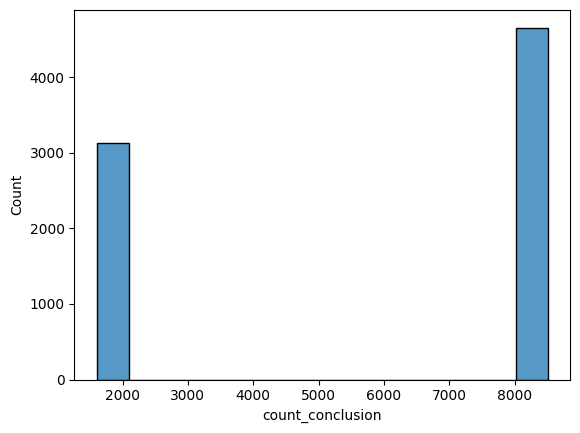

In [82]:
sns.histplot(ar['count_conclusion'])

<Axes: xlabel='confidence', ylabel='lift'>

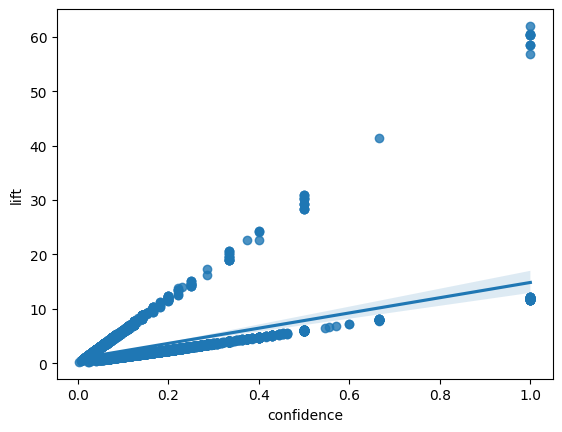

In [83]:
sns.regplot(x=ar['confidence'], y=ar['lift'])

<Axes: xlabel='support', ylabel='Count'>

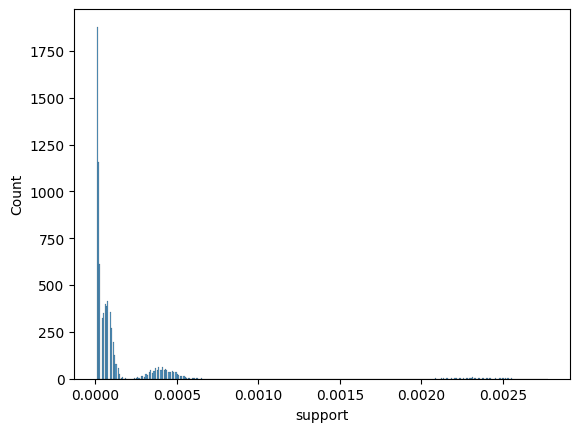

In [ ]:
m['user_id_unique'].value_counts()
sns.histplot(['support'])

In [46]:
m[m['support'] > 0.1]['sequence'].str.split(' -> ').apply(lambda x: len(x)).value_counts()
m['sequence'].str.split(' -> ').apply(lambda x: len(x)).value_counts()

sequence
8     49633
9     49598
7     49565
10    49550
6     48502
5     39174
4      9938
3      1000
Name: count, dtype: int64

In [ ]:
seq = 'asad & dsdada & svxc'
intersect_separator = ' & '
split_index = seq.rindex(intersect_separator)
premise, conclusion = seq[:split_index], seq[split_index + len(intersect_separator):]

premise, conclusion

('asad & dsdada', 'svxc')

In [27]:
m_copy = m.copy()
# m_copy.set_index('user_id', drop=True)
step_cols = list(m_copy.drop(columns=['user_id']).columns)
m_copy.groupby(step_cols)['user_id'].nunique().reset_index()

interchangeable_events = [['event1', 'event2'], ['event3', 'event4']]
# Создаем словарь для замены
replacement_dict = {}
for group in interchangeable_events:
    group_name = '/'.join(group)
    for event in group:
        replacement_dict[event] = group_name

for col in step_cols:
    m_copy[col] = m_copy[col].replace(replacement_dict)

m_copy


# Методы сравнения
class ScenarioMatcher:
    def __init__(self, ef: EventFrame):
        self.ef = ef
        

m_copy

step,user_id,1,2,3
0,user1013,event9,ENDED,ENDED
1,user1016,event1/event2,ENDED,ENDED
2,user1017,event7,event3/event4,ENDED
3,user1022,event9,ENDED,ENDED
4,user1029,event3/event4,ENDED,ENDED
...,...,...,...,...
465,user976,event1/event2,ENDED,ENDED
466,user981,event3/event4,ENDED,ENDED
467,user99,event1/event2,ENDED,ENDED
468,user992,event3/event4,ENDED,ENDED


In [50]:
user_event_counts = data.groupby(['user_id'])['event'].nunique().reset_index()
all_events_users = user_event_counts[user_event_counts['event'] == 10]['user_id']
not_all_events_users = user_event_counts[user_event_counts['event'] < 10]['user_id'].head()

In [ ]:
sm.fit(data=data[data[user_col].isin(not_all_events_users)], max_steps=10, threshold=0.05)

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event7,20.0,20.0,0.0,20.0,20.0,20.0,0.0,20.0,0.0,0.0
event5,20.0,20.0,20.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0
event3,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
event8,20.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0
event6,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
ENDED,0.0,20.0,20.0,20.0,20.0,40.0,40.0,40.0,60.0,80.0
event1,0.0,0.0,0.0,0.0,20.0,0.0,20.0,20.0,0.0,0.0
event10,0.0,20.0,0.0,20.0,0.0,0.0,20.0,0.0,20.0,0.0
event2,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0


In [54]:
sm.fit(data=data[data[user_col].isin(all_events_users)], max_steps=10, threshold=0.05)

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event5,50.0,50.0,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0
event3,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
event10,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0,0.0,0.0
event1,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
event2,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,50.0
event4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0
event6,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0
event7,0.0,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
event8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0


In [101]:
merged_matrix = sm.fit_difference(all_events_users, not_all_events_users, max_steps=10, threshold=0.05)
merged_matrix

data is None


,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
ENDED,0.0,-20.0,-20.0,-20.0,-20.0,-40.0,-40.0,-40.0,-60.0,-80.0
event1,0.0,0.0,0.0,50.0,-20.0,0.0,-20.0,-20.0,0.0,0.0
event10,0.0,-20.0,0.0,-20.0,0.0,50.0,-20.0,50.0,-20.0,0.0
event2,0.0,0.0,0.0,50.0,50.0,0.0,-20.0,0.0,0.0,50.0
event3,30.0,0.0,-20.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
event4,0.0,-20.0,-40.0,0.0,-20.0,0.0,0.0,50.0,0.0,50.0
event5,30.0,30.0,30.0,-20.0,0.0,-20.0,50.0,-20.0,0.0,0.0
event6,-20.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,-20.0
event7,-20.0,30.0,0.0,-20.0,-20.0,30.0,0.0,-20.0,0.0,0.0


data is None


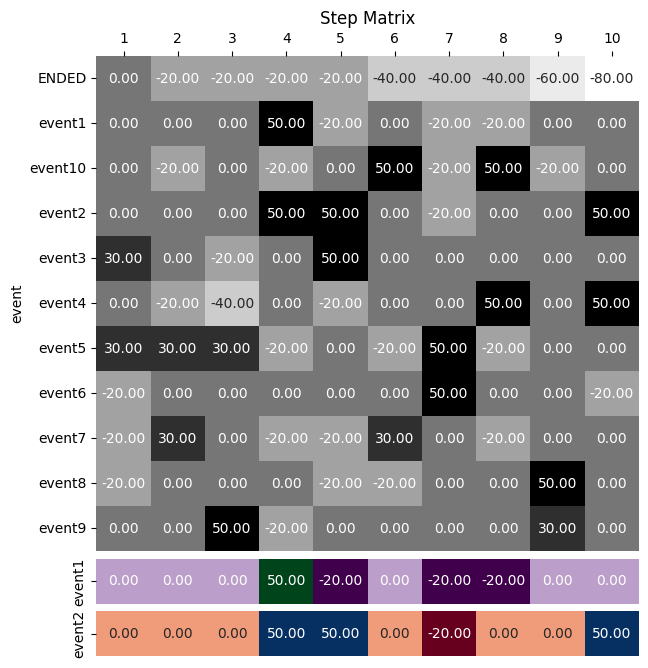

In [102]:
sm.plot_difference(all_events_users, not_all_events_users, max_steps=10, threshold=0.05, target_events=['event1', 'event2'], weight_col='user_id')

In [59]:
difference_matrix = merged_matrix.filter(like='_1').subtract(merged_matrix.filter(like='_2').values)
difference_matrix.columns = [col.replace('_1', '') for col in difference_matrix.columns]
difference_matrix

,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
ENDED,0.0,-20.0,-20.0,-20.0,-20.0,-40.0,-40.0,-40.0,-60.0,-80.0
event1,0.0,0.0,0.0,50.0,-20.0,0.0,-20.0,-20.0,0.0,0.0
event10,0.0,-20.0,0.0,-20.0,0.0,50.0,-20.0,50.0,-20.0,0.0
event2,0.0,0.0,0.0,50.0,50.0,0.0,-20.0,0.0,0.0,50.0
event3,30.0,0.0,-20.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
event4,0.0,-20.0,-40.0,0.0,-20.0,0.0,0.0,50.0,0.0,50.0
event5,30.0,30.0,30.0,-20.0,0.0,-20.0,50.0,-20.0,0.0,0.0
event6,-20.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,-20.0
event7,-20.0,30.0,0.0,-20.0,-20.0,30.0,0.0,-20.0,0.0,0.0


In [52]:
not_all_events_users

0     user1
1    user10
2    user11
3    user12
4    user13
Name: user_id, dtype: object

In [130]:

# step_cols = [i for i in range(1, max_steps + 1)]
# m.loc[:, step_cols] = m.loc[:, step_cols].divide(m.loc[:, step_cols].sum()).mul(100).round(1)
threshold: float = 0.15
normal_events = m.loc[m.max(axis=1) >= threshold * 100]
thresholded_events = m.loc[m.max(axis=1) < threshold * 100]

# Суммируем значения всех строк в thresholded_events
sum_row = thresholded_events.sum()

# Создаем новый индекс с учетом количества строк в thresholded_events
new_index = f'Thresholded_{thresholded_events.shape[0]}'

# Добавляем новую строку к normal_events
normal_events.loc[new_index] = sum_row

C:\Users\razue\AppData\Local\Temp\ipykernel_10108\3317989321.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_events.loc[new_index] = sum_row


In [131]:
normal_events

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event2,12.0,8.0,12.0,8.0,12.0,6.0,20.0,8.0,8.0,12.0
event3,12.0,14.0,8.0,18.0,12.0,6.0,8.0,6.0,12.0,16.0
event5,12.0,10.0,6.0,12.0,8.0,8.0,22.0,14.0,18.0,10.0
event10,10.0,18.0,8.0,14.0,2.0,16.0,4.0,16.0,8.0,12.0
event1,10.0,12.0,10.0,14.0,4.0,20.0,10.0,8.0,10.0,14.0
event6,8.0,8.0,22.0,10.0,8.0,6.0,6.0,10.0,10.0,6.0
event9,6.0,6.0,10.0,4.0,24.0,8.0,6.0,6.0,10.0,6.0
Thresholded_3,30.0,24.0,24.0,20.0,30.0,30.0,24.0,32.0,24.0,24.0


In [121]:
m

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event4,14.0,8.0,14.0,8.0,10.0,10.0,10.0,14.0,8.0,4.0
event2,12.0,8.0,12.0,8.0,12.0,6.0,20.0,8.0,8.0,12.0
event3,12.0,14.0,8.0,18.0,12.0,6.0,8.0,6.0,12.0,16.0
event5,12.0,10.0,6.0,12.0,8.0,8.0,22.0,14.0,18.0,10.0
event10,10.0,18.0,8.0,14.0,2.0,16.0,4.0,16.0,8.0,12.0
event1,10.0,12.0,10.0,14.0,4.0,20.0,10.0,8.0,10.0,14.0
event8,10.0,10.0,6.0,10.0,10.0,8.0,6.0,6.0,10.0,12.0
event6,8.0,8.0,22.0,10.0,8.0,6.0,6.0,10.0,10.0,6.0
event7,6.0,6.0,4.0,2.0,10.0,12.0,8.0,12.0,6.0,8.0


In [107]:
m

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event4,14.0,8.0,14.0,8.0,10.0,10.0,10.0,14.0,8.0,4.0
event2,12.0,8.0,12.0,8.0,12.0,6.0,20.0,8.0,8.0,12.0
event3,12.0,14.0,8.0,18.0,12.0,6.0,8.0,6.0,12.0,16.0
event5,12.0,10.0,6.0,12.0,8.0,8.0,22.0,14.0,18.0,10.0
event10,10.0,18.0,8.0,14.0,2.0,16.0,4.0,16.0,8.0,12.0
event1,10.0,12.0,10.0,14.0,4.0,20.0,10.0,8.0,10.0,14.0
event8,10.0,10.0,6.0,10.0,10.0,8.0,6.0,6.0,10.0,12.0
event6,8.0,8.0,22.0,10.0,8.0,6.0,6.0,10.0,10.0,6.0
event7,6.0,6.0,4.0,2.0,10.0,12.0,8.0,12.0,6.0,8.0


In [92]:
m.set_index('event')

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event6,11.6,9.4,13.0,6.4,11.0,10.6,9.4,9.0,6.2,5.4
event3,11.0,10.2,9.0,10.8,9.2,6.2,7.8,6.0,5.8,4.8
event9,10.8,8.6,11.2,8.8,9.2,9.4,8.8,6.6,5.0,5.2
event5,10.6,9.2,9.0,11.0,10.8,7.0,8.0,6.6,7.4,5.2
event4,10.2,10.4,9.4,10.0,7.2,8.0,9.8,6.6,6.4,3.8
event2,10.0,9.0,8.2,10.2,10.6,9.2,7.0,8.4,8.0,6.6
event10,9.8,10.8,9.8,11.8,10.6,10.6,8.6,7.8,6.4,6.4
event1,8.8,10.6,11.2,9.0,8.8,8.2,7.0,8.0,6.0,7.4
event7,8.6,12.0,10.2,10.0,11.2,12.4,7.4,9.0,8.8,6.6


In [50]:
data['step'] = data.groupby('user_id')['event_datetime'].cumcount() + 1
data[data['user_id'] == 'user99']

,user_id,event,event_datetime,city,operation_system,status,step
163,user99,event3,2025-03-02 21:37:10.545635,city8,iOS,status1,1
351,user99,event9,2025-01-06 21:37:10.545635,city7,Android,status2,2
370,user99,event5,2024-11-08 21:37:10.545635,city10,Android,status2,3
393,user99,event10,2025-01-13 21:37:10.545635,city3,Android,status2,4
462,user99,event8,2024-12-27 21:37:10.545635,city3,Android,status1,5
472,user99,event9,2025-01-13 21:37:10.545635,city6,Android,status2,6
